In [1]:
# from collections import Counter
# from collections import defaultdict

from einops import rearrange
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import torch.nn.functional as F


import glob
import re

import json
import pickle

import sys
from datetime import datetime as dt

# Helpers

## functions

In [2]:
def clean_line(line):
    line = line.lower()
    replace = [('\\', ' / '), ('[', ' ( '), ('{', ' ( '), (']', ' ) '), ('}', ' ) ')] # , ('/', ' / ')
    for rep in replace:
        if rep[0] in line:
            line = line.replace(rep[0], rep[1])
    line = re.sub('[^!-@_a-z ]', '', line)
    line = re.findall(r"[\w']+|[^\w\s]", line, re.UNICODE)
    return line

In [3]:
def get_data_from_file(file_name, token_map, words_tokenized, words_to_index):
    data = []
    counter = 0
    with open(file_name, 'r') as f:
        for line in f:
            word = line[:-1]
            if line == '.':
                counter += 1
                if counter > 1:
                    continue
            else:
                counter = 0
            tokens = words_tokenized[words_to_index[word]]
            enc = [token_map[tok] for tok in tokens]
            data.extend(enc)
    return torch.LongTensor(data)

In [4]:
def set_dropout(model, drop_rate):
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = drop_rate
        set_dropout(child, drop_rate = drop_rate)

In [5]:
def plot_loss(loss):
    plt.plot(loss)
    #plt.xlabel('', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.show()

# Load the data

In [6]:
my_path = 'data/guten/'

## prepare data

In [7]:
texts = glob.glob(my_path + 'clean_parts/*.txt')

In [8]:
with open(my_path + 'token_map.json', 'r') as f:
        token_map = json.load(f)
# with open(my_path + 'token_freq_0.json', 'r') as f:
#         token_freq = json.load(f)
with open(my_path + 'words_to_index.json', 'r') as f:
    words_to_index = json.load(f)
with open(my_path + 'words_tokenized_0.json', 'r') as f:
    words_tokenized = json.load(f)
rev_token_map = {v: k for k, v in token_map.items()}

In [9]:
vocab_size_in = vocab_size_out = len(token_map)
print(vocab_size_out)

14618


# training function

In [10]:
def train(model, texts, token_map, words_tokenized, words_to_index, criterion, model_optimizer, train_hp, 
          save = False):
    epochs, batch_size, seq_length, frequency, my_path, model_name = train_hp
    loss_train = []
    start_time = dt.now()
    model.train()
    
    x = torch.empty((batch_size, seq_length), dtype = torch.long, device = device)
    y_input = torch.empty((batch_size, seq_length), dtype = torch.long, device = device)
    y_input[:, 0] = token_map['^']
    y_target = torch.empty((batch_size, seq_length), dtype = torch.long, device = device)
    # for one file
    file_name = np.random.choice(texts)
    data = get_data_from_file(file_name, token_map, words_tokenized, words_to_index)
    ##
    for ep in range(1, epochs + 1):
        # for many files
#         file_name = random.choice(texts)
#         data = get_data_from_file(file_name, token_map, words_tokenized, words_to_index)
        ##
        data_len = data.size(0) - batch_size - seq_length * 2 - 1
        order = np.random.permutation(np.arange(0, data_len, seq_length // frequency))
        or_length = order.shape[0]
        loss_tempo = []
        j = 0
        for i, start_ind in enumerate(order):
            middle_ind = start_ind + seq_length
            end_ind = middle_ind + seq_length
            x[j] = data[start_ind : middle_ind]
            y_input[j, 1:] = data[middle_ind : end_ind - 1]
            y_target[j] = data[middle_ind : end_ind]
            
            j += 1
            if j % batch_size == 0:
                j = 0
                q_mask, r_mask, rt_mask = create_masks(x, y_input, y_target)
            
                out = model(x, q_mask, y_input, r_mask)
                loss = criterion(out, y_target, rt_mask)

                model_optimizer.optimizer.zero_grad()
                loss.backward()
                model_optimizer.step()

                loss_t = loss.item()
                loss_tempo.append(loss_t)
            
                elapsed = dt.now() - start_time
                secs = elapsed.seconds
                ratio = (i + 1) / or_length
                printout = '\r[%-16s] %d%%, batch: %d, %02d:%02d:%02d:%02d, epoch: %d/%d, total: %d, loss: %f'
                sys.stdout.write(printout % ('='*round(16 * ratio), round(100 * ratio), (i + 1) // batch_size, 
                                             elapsed.days, secs // 3600, secs // 60 % 60, secs % 60, ep, epochs, 
                                             model.epochs, loss_t))
                sys.stdout.flush()
        model.epochs += 1
        ep_loss = np.mean(np.asarray(loss_tempo), axis=0)
        loss_train.extend(loss_tempo)
        model.losses.append(ep_loss)
        
        if save:
            state = {'model': model, 'model_optimizer': model_optimizer, 'criterion': criterion, 
                     'model_hp' : model_hp}
            torch.save(state, my_path + model_name)
    
    sys.stdout.write('\n')
    return loss_train

## evaluating function

In [11]:
def get_data_from_line(model_token, line, words_tokenized, words_to_index, word_length, token_map, rev_token_map, 
                       parallel):
    data = []
    # specialy for this guten dialog
    line = line.replace(',', '.')
    ##
    words = clean_line(line)
    for word in words:
        tokens = []
        if word in words_to_index:
            tokens = words_tokenized[words_to_index[word]]
        else:
            tokens = tokenize_word(model_token, word, word_length, token_map, rev_token_map, parallel)
        enc = [token_map[tok] for tok in tokens]
        data.extend(enc)
    return torch.LongTensor(data)

In [12]:
def tokenize_word(model, question, word_length, token_map, rev_token_map, parallel):
    """
    Performs Greedy Decoding with a batch size of 1
    """    
    
    question = list(question) + ['^'] 
    question = [token_map[t] for t in question]
    question = torch.LongTensor(question).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    start_token = token_map['^']
    reply = [[start_token]]
    reply = torch.LongTensor(reply).to(device)
    model.eval()
    with torch.no_grad():
        for step in range(word_length - 1):
            dims = reply.size(-1)
            reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
            reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
            if parallel:
                decoded = model.encode_decode(question, question_mask, reply, reply_mask)
            else:
                encoded = model.encode(question, question_mask)
                decoded = model.decode(encoded, question_mask, reply, reply_mask)
            predictions = model.out(decoded[:, -1])
            next_word = torch.argmax(predictions, dim = 1)
            next_word = next_word.item()
            reply = torch.cat([reply, torch.LongTensor([[next_word]]).to(device)], dim = 1)
            if rev_token_map[next_word][-1] == '^':
                break

        # Construct Sentence
        if reply.dim() == 2:
            reply = reply.squeeze(0)
            reply = reply.tolist()

        word = [rev_token_map[k] for k in reply[1:]]
    
    return word

In [13]:
def evaluate(model, question, seq_length, token_map, rev_token_map, parallel):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    
    start_token = token_map['^']
    reply = [[start_token]]
    reply = torch.LongTensor(reply).to(device)
    final_reply = []
    model.eval()
    with torch.no_grad():
        question_mask = (question != 0).to(device).unsqueeze(1).unsqueeze(1)
        length = 0
        while True:
            dims = reply.size(-1)
            reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
            reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
            if parallel:
                decoded = model.encode_decode(question, question_mask, reply, reply_mask)
            else:
                encoded = model.encode(question, question_mask)
                decoded = model.decode(encoded, question_mask, reply, reply_mask)
            prediction = model.out(decoded[:, -1])
            next_word = torch.argmax(prediction, dim = 1).item()
            final_reply.append(next_word)
            if reply.shape[1] < 32:
                reply = torch.cat([reply, torch.LongTensor([[next_word]]).to(device)], dim = 1) 
            else:
                reply = torch.cat([reply[:, 1:], torch.LongTensor([[next_word]]).to(device)], dim = 1)
            if next_word != 4:
                length += 1
                if length > answer_len:
                    break
                
    final_reply = ''.join([rev_token_map[w] for w in final_reply])
    final_reply = final_reply.replace('^', ' ')
    final_reply = re.sub(r'(?<=[,.\-()":=&;!/$\+%<>_#?\*@1234567890])', r' ', final_reply)
    return final_reply

# Create the model

In [14]:
%run Transformer_class.ipynb

In [15]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
def create_order(d_emb, repeat, deep):
    order = []
    hidden = [d_emb * 2, d_emb, d_emb, d_emb // 2]
    for dh in hidden:
        h = dh // 16
        for _ in range(deep):
            for _ in range(repeat):
                order.append((dh, h))
            h = max(1, h // 2)
    return order

In [18]:
d_emb = 256
hidden_mult = 4
seq_length = 64
order = create_order(d_emb, 1, 4)
# order = [(512, 32), (512, 16), (512, 8), (512, 4), 
#          (256, 16), (256, 8), (256, 4), (256, 2),
#          (128, 8), (128, 4), (128, 2), (128, 1)]
dropouts = [0, 0, 0]
parallel = True

In [19]:
flag_load = True
model_name = 'trans_220804_par.pt'

In [20]:
if flag_load:
    state = torch.load(my_path + model_name)
    model_hp = state['model_hp']
    model = state['model']
    model_optimizer = state['model_optimizer']
    criterion = state['criterion']
    vocab_size_in, vocab_size_out, d_emb, hidden_mult,  seq_length, order, dropouts, parallel = model_hp
else:
    model_hp = vocab_size_in, vocab_size_out, d_emb, hidden_mult, seq_length, order, dropouts, parallel
    model = Transformer(model_hp).to(device)
    #model = nn.DataParallel(model, device_ids = [0, 1, 2, 3])
    #model.to(f'cuda:{model.device_ids[0]}')
    l2 = 0.0
    learning_rate = 0
    warmup_steps = 4096
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2, amsgrad=False)
    model_optimizer = AdamWarmup(d_emb, warmup_steps, optimizer)
    criterion = LossWithLS(vocab_size_out, 0.1)

In [21]:
print('vocab_size_in', vocab_size_in)
print('vocab_size_out', vocab_size_out)
print('d_emb', d_emb)
print('hidden_mult', hidden_mult)
print('seq_length', seq_length)
print('order', order)
print('dropouts', dropouts)
print('parallel', parallel)
print('num of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

vocab_size_in 14618
vocab_size_out 14618
d_emb 256
hidden_mult 4
seq_length 64
order [(512, 32), (512, 16), (512, 8), (512, 4), (256, 16), (256, 8), (256, 4), (256, 2), (256, 16), (256, 8), (256, 4), (256, 2), (128, 8), (128, 4), (128, 2), (128, 1)]
dropouts [0, 0, 0]
parallel True
num of parameters: 42416410


# Running

## Train

In [24]:
epochs = 4
batch_size = 64
frequency = 2
train_hp = epochs, batch_size, seq_length, frequency, my_path, model_name

In [ ]:
loss_train = train(model, texts, token_map, words_tokenized, words_to_index, criterion, model_optimizer, train_hp, 
                  save = True)

[=               ] 4%, batch: 6516, 00:00:48:08, epoch: 1/4, total: 9, loss: 4.377866

total epochs 9


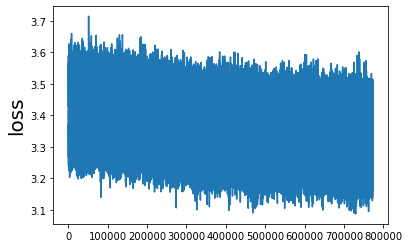

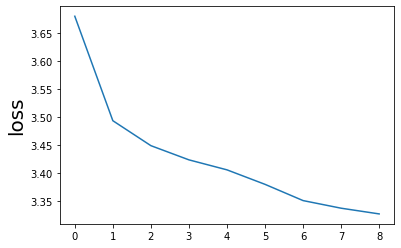

In [39]:
print('total epochs', model.epochs)
plot_loss(loss_train)
plot_loss(model.losses)

## Evaluate

In [40]:
flag_load = True

In [41]:
if flag_load:
    state = torch.load(my_path + 'tokenizer.pt')
    tokenizer = state['model'].to(device)

In [ ]:
word_length = 32
answer_len = 64
while(1):
    question = input("You: ") 
    if question == 'quit':
        break
    question = get_data_from_line(tokenizer, question, words_tokenized, words_to_index, word_length, token_map, 
                                  rev_token_map, parallel)
    question = question.to(device).unsqueeze(0)
    reply = evaluate(model, question, seq_length, token_map, rev_token_map, parallel)
    
    print(reply)

In [23]:
set_dropout(model, 0.05)

# Works

In [17]:
texts = glob.glob(my_path + 'parts/*.txt')

In [18]:
file_name = random.choice(texts)

In [21]:
char_to_num, num_to_char = create_char_dict()

In [22]:
word_length = 16

In [31]:
def get_data_from_file(file_name, word_map, word_length, char_to_num):
    data = []
    target = []
    with open(file_name, 'r') as f:
        for line in f:
            l = remove_punc(line)
            words = l.split()
            enc_words = []
            enc_chars = []
            for word in words:
                enc_words.append(word_map.get(word, word_map['<unk>']))
                w = torch.zeros(word_length)
                for i, char in enumerate(word[:word_length]):
                    w[i] = char_to_num[char]
                enc_chars.append(w)
                    
            data.extend(enc_words)
            target.extend(enc_chars)
    return torch.LongTensor(data), torch.stack(target).long()

In [32]:
data, target = get_data_from_file(file_name, word_map, word_length, char_to_num)

In [33]:
data.shape

torch.Size([1781716])

In [40]:
targ = torch.stack(target).long()

In [299]:
word_length = 16
seq_length = 32
batch_size = 64
layers = [1, 8, 16, 32]
d_emb = 256
dropout = 0

In [38]:
file_name = random.choice(texts)
data = get_data_from_file(file_name, word_length, char_to_num)

In [39]:
data.shape

(1976683, 16)

In [76]:
#data_len = len(data) - batch_size - seq_length
batch = 0
x = []
y_input = []
y_target = []
for word in range(batch_size):
    start_ind = batch + word
    middle_ind = start_ind + seq_length
    end_ind = middle_ind + seq_length
    x.append(data[start_ind : middle_ind])
    y_input.append(data[middle_ind - 1 : end_ind - 1])
    y_target.append(data[middle_ind : end_ind])

In [77]:
x = torch.as_tensor(x)#.to(device)
y_input = torch.as_tensor(y_input)#.to(device)
y_target = torch.as_tensor(y_target)#.to(device)

In [78]:
x.shape

torch.Size([64, 32, 16])

In [81]:
embedd = Embedder(word_length, emb_layers, d_emb, 0, seq_length)

In [82]:
line = 'hi how'
ques = get_data_from_line(line, word_length, char_to_num)
ques = torch.Tensor(ques).unsqueeze(0)

In [83]:
ques.shape

torch.Size([1, 2, 16])

In [84]:
x_out = embedd(ques.float())

torch.Size([2, 1, 16])
torch.Size([2, 32, 16])


In [85]:
x_out.shape

torch.Size([1, 2, 256])

In [ ]:
model.eval()
with torch.no_grad():
    encoded = model.encode(question)
    reply = [question[:, -1, :]]# + [word_map['<pad>']] * 31]
    reply = torch.Tensor(reply).to(device)
    for step in range(3):
        dims = reply.size(-1)
        reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
        reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = model.decode(encoded, reply)
        #print(decoded.shape)
        predictions = model.out(decoded[:, -1])
        out = model.out_1(decoded)
        out = F.relu(out)
        out = model.out_2(out)
        out = F.sigmoid(out)
        out = out.item()

        reply = torch.cat([reply, torch.Tensor([[out]]).to(device)], dim = 1) 


In [79]:
x_out = embedd(x.float())

torch.Size([2048, 1, 16])
torch.Size([2048, 32, 16])


In [308]:
x_out.shape

torch.Size([64, 32, 256])

torch.Size([1, 2, 16])

In [31]:
torch.cuda.get_device_properties(0).total_memory

4226547712

 Costa            Rica             and              Qater            each             made             their            debut            in               the              event.           The              United           States           appeared         for              the              26th             time,            most             of               any              nation,          having           missed           only             the              boycotted        1980             Games.           Summary.         The              hammer          


In [214]:
class CBOWModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        embeds = self.embeddings(x).view(1,-1)
        output = self.linear1(embeds)
        output = F.relu(output)
        output = self.linear2(output)
        log_probs = F.log_softmax(output, dim=1)
        return log_probs

In [ ]:
torch.einsum('...td,...id->...ti', tens1, tens2)

In [ ]:
rearrange(tens2, '... i j -> ... (i j)')

In [30]:
tens1.size(-1)

4

In [23]:
torch.triu_indices(5, 5, offset = 1)

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
        [0, 1, 2, 3, 4, 1, 2, 3, 4, 2, 3, 4, 3, 4, 4]])

(4, 5, 3, 2)

In [37]:
tempo = torch.einsum('...ij->...ji', tens2)
tempo

tensor([[[7, 4],
         [6, 8],
         [6, 9]],

        [[6, 4],
         [5, 5],
         [3, 5]],

        [[4, 7],
         [1, 7],
         [3, 2]],

        [[3, 9],
         [5, 9],
         [6, 2]]])

In [39]:
torch.einsum('...ij,...jk->...ik', tens1, tempo)

tensor([[[ 86,  72],
         [136, 169]],

        [[ 91,  89],
         [ 75,  67]],

        [[ 66, 121],
         [ 46, 105]],

        [[ 66, 130],
         [ 78, 118]]])

In [40]:
torch.einsum('...ij,...kj->...ik', tens1, tens2)

tensor([[[ 86,  72],
         [136, 169]],

        [[ 91,  89],
         [ 75,  67]],

        [[ 66, 121],
         [ 46, 105]],

        [[ 66, 130],
         [ 78, 118]]])

In [2]:
arr = torch.rand(2, 3, 4)
arr

tensor([0.6391, 0.9772, 0.2742])

In [4]:
arr = []
for _ in range(5):
    arr.append(torch.rand(2, 3, 4))

In [5]:
torch.stack(arr).shape

torch.Size([5, 2, 3, 4])

In [45]:
arr1 = torch.rand(3)
arr1

tensor([0.6118, 0.5302, 0.4942])

In [46]:
arr * arr1

tensor([0.1638, 0.3527, 0.2306])

In [89]:
arr.min(axis = (0,2))

array([2, 1, 1])

In [8]:
dr = 0

In [5]:
if dr:
    dr = 5
else:
    dr = None
print(dr)

5


In [9]:
dr = 4 if dr else None
print(dr)

None


# Archive